<a href="https://colab.research.google.com/github/YuriSerhiienko/data_science_hw8/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation == 1:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        # Вихідний шар
        self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.output_layer(x, activation=1)


In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Передбачені класи - це індекси з максимальним значенням у передбаченнях
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислення точності, перетворивши булеві значення в числові та знаходячи середнє
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

Step: 100, Loss: 290.6352844238281, Accuracy: 0.6953125
Step: 200, Loss: 238.15716552734375, Accuracy: 0.7265625
Step: 300, Loss: 187.56858825683594, Accuracy: 0.8203125
Step: 400, Loss: 150.5609130859375, Accuracy: 0.81640625
Step: 500, Loss: 123.307861328125, Accuracy: 0.85546875
Step: 600, Loss: 163.35348510742188, Accuracy: 0.8203125
Step: 700, Loss: 97.95309448242188, Accuracy: 0.8984375
Step: 800, Loss: 113.11050415039062, Accuracy: 0.87890625
Step: 900, Loss: 111.4009780883789, Accuracy: 0.85546875
Step: 1000, Loss: 87.99207305908203, Accuracy: 0.8671875
Step: 1100, Loss: 106.30477905273438, Accuracy: 0.875
Step: 1200, Loss: 76.84454345703125, Accuracy: 0.89453125
Step: 1300, Loss: 96.35992431640625, Accuracy: 0.8828125
Step: 1400, Loss: 96.28617858886719, Accuracy: 0.890625
Step: 1500, Loss: 58.555206298828125, Accuracy: 0.9296875
Step: 1600, Loss: 78.27037811279297, Accuracy: 0.89453125
Step: 1700, Loss: 107.42797088623047, Accuracy: 0.875
Step: 1800, Loss: 78.295166015625, Ac

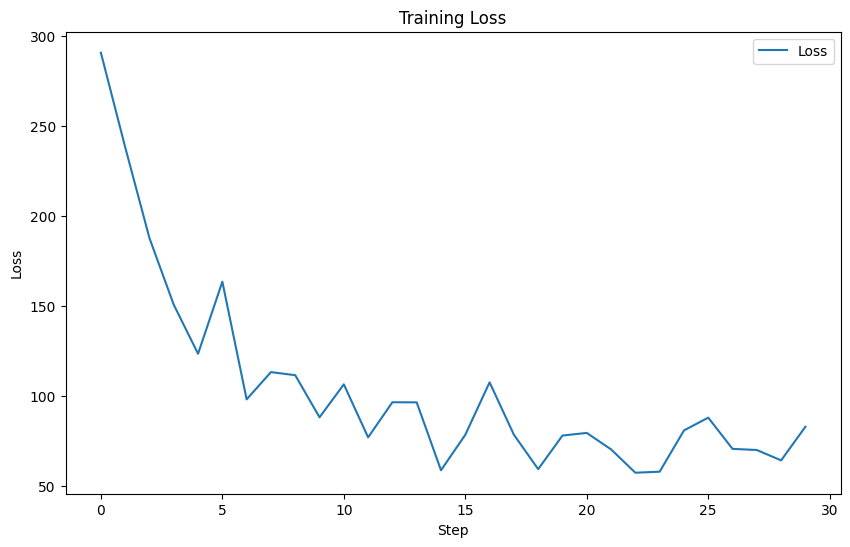

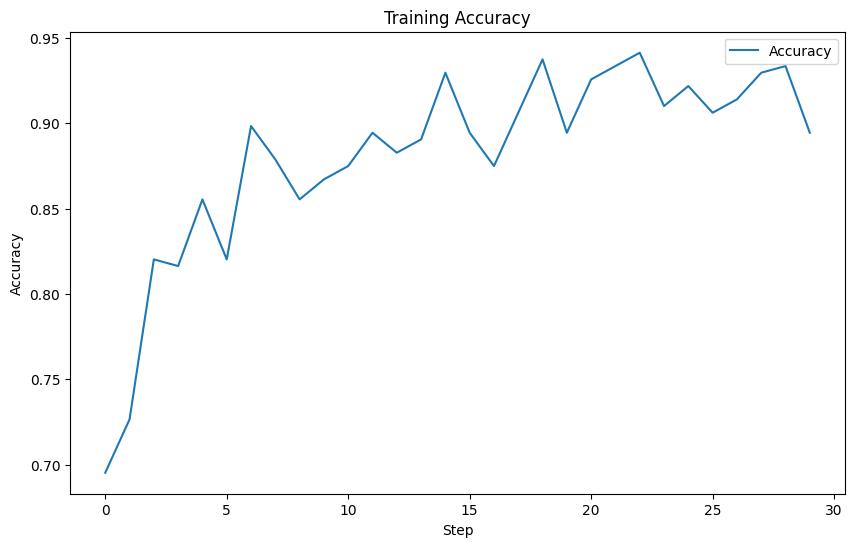

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
train_predictions = neural_net(x_train)
train_accuracy = accuracy(train_predictions, y_train)
print(f"Точність на тренувальних даних: {train_accuracy.numpy()}")

# Тестування моделі на тестових даних
test_predictions = neural_net(x_test)
test_accuracy = accuracy(test_predictions, y_test)
print(f"Точність на тестових даних: {test_accuracy.numpy()}")


Точність на тренувальних даних: 0.9205833077430725
Точність на тестових даних: 0.8996999859809875


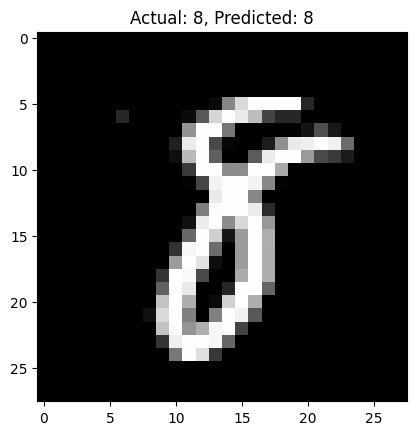

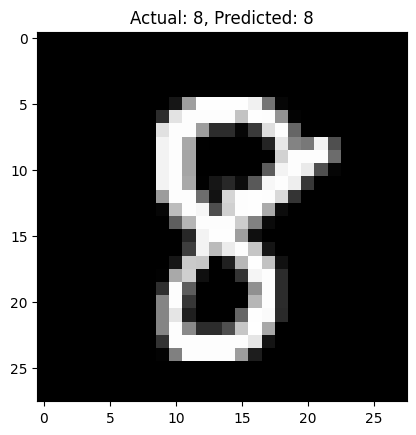

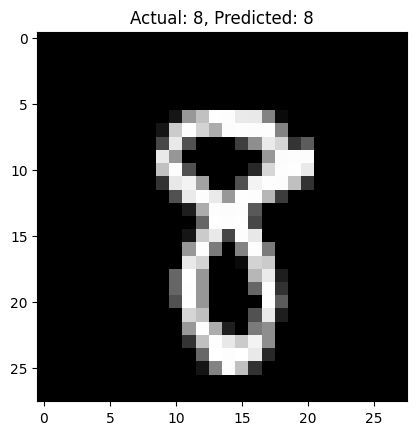

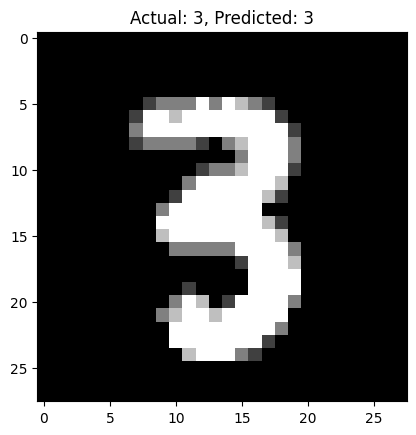

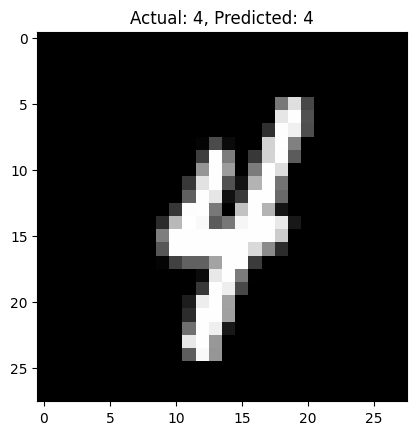

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду


# Вибираємо 5 випадкових індексів
random_indices = np.random.choice(x_test.shape[0], 5)
# Отримуємо випадкові зображення та їх фактичні мітки
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Отримуємо передбачення нейронної мережі
predictions = neural_net(random_images)

# Візуалізуємо результати
for i in range(5):
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Actual: {random_labels[i]}, Predicted: {np.argmax(predictions.numpy()[i], axis=0)}")
    plt.show()


Після аналізу результатів тренування і тестування моєї нейронної мережі, я бачу, що вона показує досить високу точність – 92% на тренувальних даних і майже 90% на тестових. Це означає, що мережа нечасто помиляється, приблизно в 10% випадків на нових даних. Перевірка на окремих прикладах також показала хороші результати, оскільки всі передбачення були правильними. Вважаю, що мережа добре справляється з завданням розпізнавання рукописних цифр